In [ ]:
# @title libraries & packages

# utilities and viz
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# file management
import pickle
import zipfile
import requests
import os

# signal processing and viz
import librosa
from librosa import load as load_audio
from librosa.display import specshow, waveshow
from librosa.feature import mfcc, spectral_centroid
import IPython.display as ipd

# loops progress bar
from tqdm import tqdm
tqdm.pandas()

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# classification
import sklearn
from sklearn.svm import SVC
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

# Data processing

## Data import

Original data and info: https://www.nature.com/articles/s41597-021-00937-4

In [ ]:
# download from url function
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [ ]:
# raw data download
os.mkdir('/content/data/')
download_url('https://zenodo.org/records/7024894/files/public_dataset_v3.zip?download=1,', '/content/data/dataset.zip')
# file extraction
with zipfile.ZipFile('/content/data/dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/data/')

In [ ]:
# meatdata import
metadata = pd.read_csv('/content/data/coughvid_20211012/metadata_compiled.csv')
metadata

,Unnamed: 0,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,00098cdb-4da1-4aa7-825a-4f1b9abc214b,2021-01-22T22:08:06.742577+00:00,0.1133,47.4,9.4,66.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,40.0,-75.1,34.0,male,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34429,34429,fff3ff61-2387-4139-938b-539db01e6be5,2020-06-28T21:28:21.530881+00:00,0.5257,51.6,-0.2,NaN,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34430,34430,fff474bf-39a4-4a61-8348-6b992fb5e439,2020-04-10T05:10:36.787070+00:00,0.1945,-39.0,-68.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34431,34431,fffaa9f8-4db0-46c5-90fb-93b7b014b55d,2020-04-13T18:58:26.954663+00:00,0.0243,41.0,28.8,50.0,male,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34432,34432,fffce9f0-a5e8-4bee-b13b-c671aac4a61c,2020-04-14T13:02:33.307684+00:00,0.9754,41.0,28.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data selection

In [ ]:
# missing data
metadata.isna().sum()

Unnamed: 0                   0
uuid                         0
datetime                     0
cough_detected               0
latitude                 15003
longitude                15003
age                      15038
gender                   13770
respiratory_condition    13770
fever_muscle_pain        13770
status                   13770
status_SSL               26103
quality_1                33614
cough_type_1             33614
dyspnea_1                33614
wheezing_1               33614
stridor_1                33614
choking_1                33614
congestion_1             33614
nothing_1                33614
diagnosis_1              33614
severity_1               33614
quality_2                33614
cough_type_2             33615
dyspnea_2                33614
wheezing_2               33614
stridor_2                33614
choking_2                33614
congestion_2             33614
nothing_2                33614
diagnosis_2              33614
severity_2               33614
quality_

In [ ]:
# recording selection
# filter for recoding with known age, gender, respiratory condition,
# and cough_detected => 0.8 (suggested by dataset publisher)
metadata_sel = metadata[(metadata.status.notna())   &
                        (metadata.age.notna())      &
                        (metadata.gender.notna())   &
                        (metadata.cough_detected >= 0.8) ]

# gender can assume 3 values: male, female, and other; only <100 of 10000+ observations have gender 'other'.
# I decided to drop such observation due to imbalance concerns.
metadata_sel = metadata_sel[metadata_sel.gender != 'other']

# reset index
metadata_sel.reset_index(inplace=True)
metadata_sel

# drop records which present status 'healthy' but report fever/musce pain
drop_id = np.where([metadata_sel.fever_muscle_pain & (metadata_sel.status=='healthy')])[1]
metadata_sel = metadata_sel.drop(index=drop_id, axis=1)

# compute the number of expert who labled the audio
diagnosis_cols = ['diagnosis_1','diagnosis_2','diagnosis_3','diagnosis_4']
expert_labled = metadata_sel[diagnosis_cols].notna().sum(axis=1)
metadata_sel['expert_labled'] = expert_labled

# map and store experts' diagnosis to status lables:
# lower_infection, upper_infection -> symptomatic
# COVID-19 -> COVID-19
# healthy_cough -> healthy
for col in diagnosis_cols:
  new = []
  for i in list(metadata_sel[col]):
    if i == 'COVID-19':
      new.append('COVID-19')
    elif i=='healthy_cough':
      new.append('healthy')
    elif i in ['lower_infection','upper_infection']:
      new.append('symptomatic')
    else:
      new.append(np.nan)
  metadata_sel[col] = new

# identify a unique expert diagnosis for each record (nan if not labled)
# for cases were an audio was labled by more than one expert mode was used
# for cases where mode is not unique 'symptomatic' was chosen as a middle ground
new = []
for row in metadata_sel.itertuples():
  if row.expert_labled == 0:
    new.append(np.nan)
  else:
    temp = pd.Series([row.diagnosis_1,row.diagnosis_2,row.diagnosis_3,row.diagnosis_4])
    mode = temp.mode()
    if len(mode)==1:
      new.append(mode[0])
    else:
      new.append('symptomatic')
metadata_sel['diagnosis'] = new

# create a binary version of status and siagnosis: healthy or not healthy
metadata_sel['status_healthy'] = (metadata_sel.status=='healthy')
metadata_sel['diagnosis_healthy'] = (metadata_sel.diagnosis=='healthy')

# feature selection
metadata_sel = metadata_sel[['uuid','age','gender','cough_detected','status',
                             'status_healthy','respiratory_condition','fever_muscle_pain',
                             'expert_labled','diagnosis','diagnosis_healthy']]
metadata_sel.reset_index(inplace=True)
metadata_sel

,index,uuid,age,gender,cough_detected,status,status_healthy,respiratory_condition,fever_muscle_pain,expert_labled,diagnosis,diagnosis_healthy
0,0,00039425-7f3a-42aa-ac13-834aaa2b6b92,15.0,male,0.9609,healthy,True,False,False,0,NaN,False
1,1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,34.0,male,0.9301,healthy,True,True,False,0,NaN,False
2,2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,21.0,male,0.9968,healthy,True,False,False,0,NaN,False
3,3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,28.0,female,0.8937,healthy,True,False,False,0,NaN,False
4,4,00291cce-36a0-4a29-9e2d-c1d96ca17242,15.0,male,0.9883,healthy,True,False,False,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
12164,12828,ffe0658f-bade-4654-ad79-40a468aabb03,22.0,male,0.9846,COVID-19,False,True,True,0,NaN,False
12165,12829,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,31.0,male,0.9485,symptomatic,False,False,False,0,NaN,False
12166,12830,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,23.0,male,0.9498,healthy,True,False,False,1,healthy,True
12167,12831,ffeea120-92a4-40f9-b692-c3865c7a983f,22.0,female,0.9784,healthy,True,False,False,0,NaN,False


In [ ]:
print('missing data summary:\n')
print(metadata_sel.isna().sum())
num_diag = metadata_sel['diagnosis'].notna().sum()
print('\nnumber of expert diagnosis: '+str(num_diag)+' ('+ str(round(num_diag/len(metadata_sel)*100,2))+'% of samples)')

missing data summary:

index                        0
uuid                         0
age                          0
gender                       0
cough_detected               0
status                       0
status_healthy               0
respiratory_condition        0
fever_muscle_pain            0
expert_labled                0
diagnosis                10172
diagnosis_healthy            0
dtype: int64

number of expert diagnosis: 1997 (16.41% of samples)


In [ ]:
np.unique(np.array(metadata_sel['gender']), return_counts=True)

(array(['female', 'male'], dtype=object), array([4052, 8117]))

## Data exploration

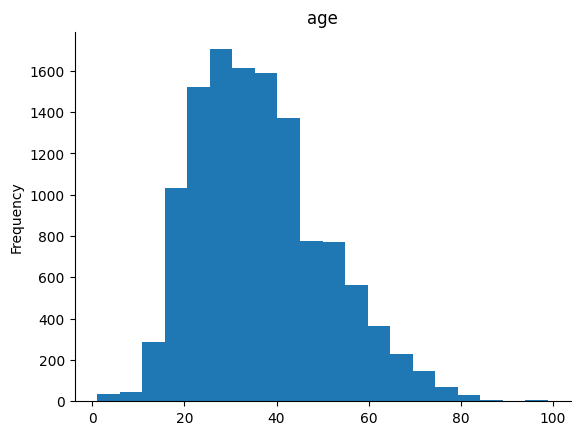

In [ ]:
# @title Age distribution
metadata_sel['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

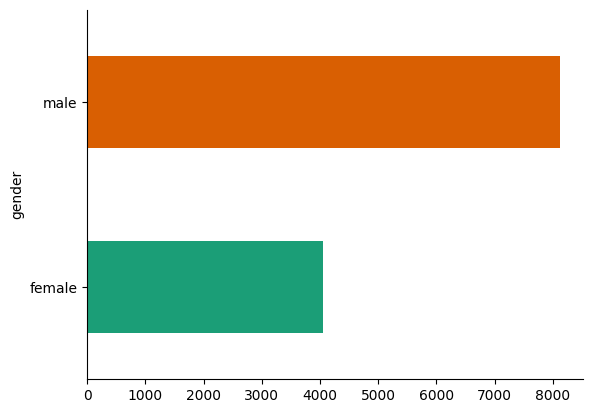

In [ ]:
# @title Gender distribution
metadata_sel.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

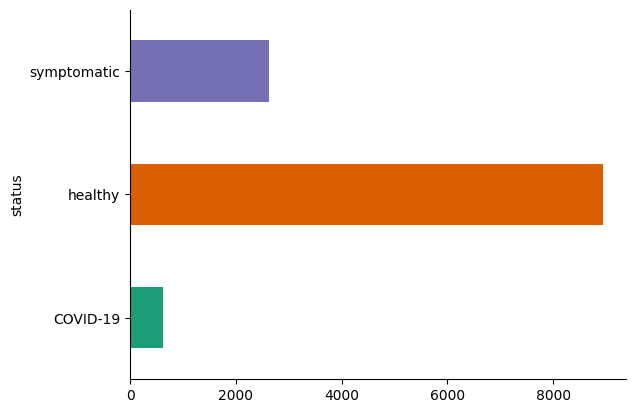

In [ ]:
# @title Status distribution
metadata_sel.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

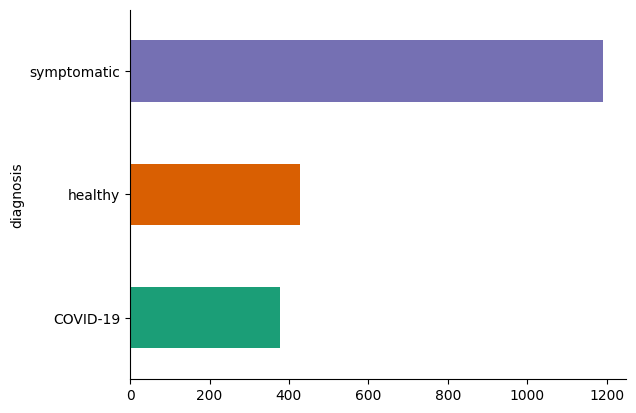

In [ ]:
# @title Diagnosis distribution
metadata_sel.groupby('diagnosis').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


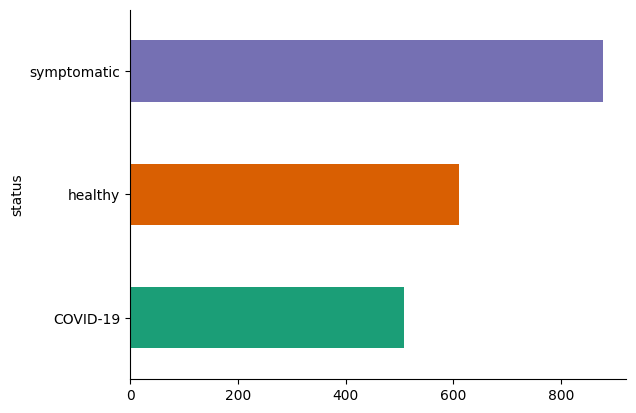

In [ ]:
# @title Status distribution of expert labled recordings
metadata_sel[metadata_sel.diagnosis.notna()].groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

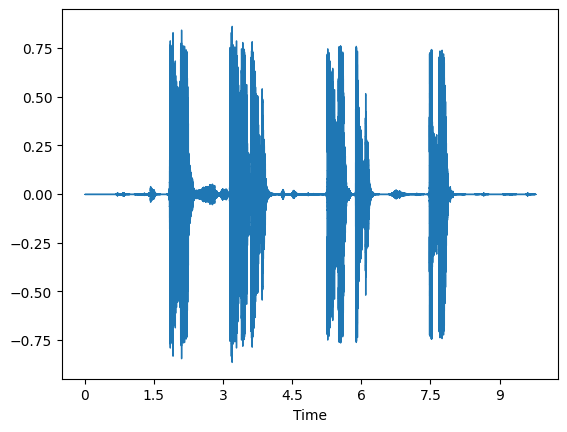

In [ ]:
# @title Recording waveform visualization and play
rec, sr = load_audio('/content/data/coughvid_20211012/00291cce-36a0-4a29-9e2d-c1d96ca17242.webm')
waveshow(rec)
ipd.Audio(rec, rate=sr)

# Audio segmentation and spectrogram extraction

In [ ]:
# create a dictionary for managing different audio format
audio_format_dict = {}
for f in sorted(os.listdir('/content/data/coughvid_20211012/')):
  if not f.endswith('.json'):
    (name, ext) = os.path.splitext(f)
    audio_format_dict[name] = ext

In [ ]:
# finds and isolates coughs within an audio by syuding energy over time wave form (see example visualized)

from scipy.signal import find_peaks

def isolate_cough(rec, sr, t_target):
  ## compute root mean square energy over time frames
  x = librosa.feature.rms(y=rec)[0]
  # min max normalization [0,1]
  x = (x-x.min())
  x = x/x.max()

  ## individuate signal peaks (experimental parameter)
  peaks, properties = find_peaks(x, width=2, prominence= 0.5)
  # select peaks (rule: max overlap t_target/2)
  max_overlap_frames = librosa.time_to_frames(t_target/2, sr=sr)
  starts = np.rint(properties['left_ips']).astype(int)
  if len(starts)==0:
    return []
  starts_sel=[starts[0]]
  if len(starts)>1:
    for i,strt in enumerate(starts[1:]):
      if (strt - starts[i])>max_overlap_frames:
        starts_sel.append(strt)

  ## extract peaks
  rec_len = len(rec)
  coughs = []
  for i,strt in enumerate(starts_sel):
    rec_index_start = librosa.frames_to_samples(strt)
    rec_index_end = rec_index_start + sr*t_target
    sample = rec[rec_index_start:rec_index_end]
    if rec_index_end <= rec_len:
      coughs.append(sample)
    elif rec_index_end-max_overlap_frames*sr <= rec_len:
      coughs.append(np.concatenate((sample,np.zeros(rec_index_end-rec_len)),axis=None))
  return coughs

In [ ]:
# ## aplly isolate_cough to all recordings and save the clips' mfcc and mel spectrograms into a dataframe

# # create an empty dataframe
# coughs_df = pd.DataFrame(columns=('uuid', 'prog', 'mel_spec', 'mfcc'))

# # aplly isolate_cough to all recordings
# for f in tqdm(metadata_sel.uuid):
#   rec, sr = load_audio('/content/data/coughvid_20211012/' + f + audio_format_dict[f])
#   coughs = isolate_cough(rec,sr,2)
#   # extract and save mfccs into df
#   for i,cough in enumerate(coughs):
#     cur_mel = librosa.feature.melspectrogram(y=cough, sr=sr, n_fft=1024)
#     cur_S_dB = librosa.power_to_db(cur_mel, ref=np.max)
#     cur_mfcc = mfcc(S=cur_S_dB)
#     cur_dict = {'uuid':[f] , 'prog':[i], 'mel_spec':[cur_S_dB], 'mfcc':[cur_mfcc]}
#     cur_entry = pd.DataFrame.from_dict(cur_dict)
#     coughs_df = pd.concat([coughs_df, cur_entry], ignore_index=True)
# coughs_df

100%|██████████| 12169/12169 [48:43<00:00,  4.16it/s]


,uuid,prog,mel_spec,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,0,"[[-79.47978, -46.708015, -37.06755, -35.75215,...","[[-889.4925, -506.90012, -348.68088, -331.9238..."
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,1,"[[-80.0, -46.147816, -36.391365, -46.22757, -5...","[[-903.8082, -462.52716, -396.05963, -496.2419..."
2,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0,"[[-64.58925, -41.23861, -29.949255, -40.059586...","[[-581.22046, -441.2168, -417.69836, -408.7375..."
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,1,"[[-44.95310825440177, -52.13346221336771, -42....","[[-583.2834931765963, -464.4748148194519, -453..."
4,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0,"[[-54.15815, -30.446606, -38.034794, -44.34784...","[[-692.4205, -309.34384, -274.4766, -303.20404..."
...,...,...,...,...
23174,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,2,"[[-80.0, -51.852707, -37.71869, -48.245567, -3...","[[-902.3189, -427.1466, -304.74515, -286.61664..."
23175,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,0,"[[-66.16517, -47.74669, -36.226467, -35.426918...","[[-812.72266, -556.7373, -431.46884, -441.1711..."
23176,ffeea120-92a4-40f9-b692-c3865c7a983f,0,"[[-80.0, -44.35447, -31.459274, -49.961884, -5...","[[-905.0967, -415.8689, -307.7343, -391.33337,..."
23177,ffeea120-92a4-40f9-b692-c3865c7a983f,1,"[[-59.765297, -53.43869, -44.30625, -41.577538...","[[-834.8248, -569.4282, -333.76074, -333.09717..."


In [ ]:
# ## extract all recordings and save the respective mfcc and mel spectrograms into a dataframe

# # create an empty dataframe
# coughs_df = pd.DataFrame(columns=('uuid', 'mel_spec', 'mfcc'))

# for f in tqdm(metadata_sel.uuid):
#   rec, sr = load_audio('/content/data/coughvid_20211012/' + f + audio_format_dict[f])
#   # extract and save mfccs into df
#   cur_mel = librosa.feature.melspectrogram(y=rec, sr=sr, n_fft=1024)
#   cur_S_dB = librosa.power_to_db(cur_mel, ref=np.max)
#   cur_mfcc = mfcc(S=cur_S_dB)
#   cur_dict = {'uuid':[f] , 'mel_spec':[cur_S_dB], 'mfcc':[cur_mfcc]}
#   cur_entry = pd.DataFrame.from_dict(cur_dict)
#   coughs_df = pd.concat([coughs_df, cur_entry], ignore_index=True)
# coughs_df

100%|██████████| 12169/12169 [43:21<00:00,  4.68it/s]


,uuid,mel_spec,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,"[[-80.0, -80.0, -80.0, -40.253853, -37.778214,...","[[-905.0967, -905.0967, -905.0967, -446.28165,..."
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -61.36065...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
4,00291cce-36a0-4a29-9e2d-c1d96ca17242,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
...,...,...,...
12164,ffe0658f-bade-4654-ad79-40a468aabb03,"[[-80.0, -75.99041, -76.52704, -80.0, -80.0, -...","[[-905.0967, -904.74225, -904.78973, -905.0967..."
12165,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
12166,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
12167,ffeea120-92a4-40f9-b692-c3865c7a983f,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -903.2958, -903.843, -..."


In [ ]:
# ## Saving mfccs
# import pickle

# file_path = '/content/drive/MyDrive/WIP/DSIM/project/coughs_mfccs_mel_2s.pickle'
# with open(file_path, 'wb') as file:
#     # Serialize and write the variable to the file
#     pickle.dump(coughs_df, file)

# print("The variable 'data' has been saved successfully.")

The variable 'data' has been saved successfully.


### Exemple visualized

In [ ]:
test_audio = 256
metadata_sel.iloc[test_audio]

uuid                     077ccf6a-f8c4-4b13-9752-7a6126638c81
age                                                      36.0
gender                                                   male
cough_detected                                         0.8345
SNR                                                       0.0
status                                                healthy
respiratory_condition                                   False
fever_muscle_pain                                       False
expert_labled                                               0
diagnosis                                                 NaN
Name: 272, dtype: object

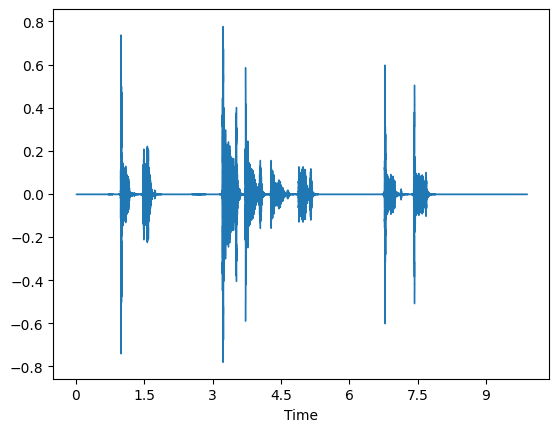

In [ ]:
f = metadata_sel.uuid[test_audio]
rec, sr = load_audio('/content/data/' + f + audio_format_dict[f])
waveshow(rec)
ipd.Audio(rec, rate=sr)

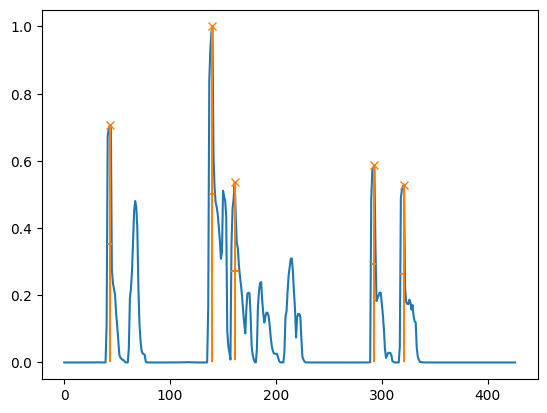

In [ ]:
# compute rms energy and 0-1 normalization
x = librosa.feature.rms(y=rec)[0]
x = (x-x.min())
x = x/x.max()

# plot rms energy and found peaks
peaks, properties = find_peaks(x, width=2, prominence= 0.5)
properties["prominences"], properties["widths"]
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
           ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

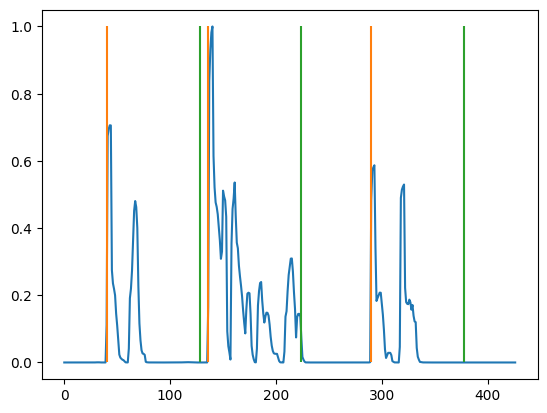

In [ ]:
# select peaks
starts = np.rint(properties['left_ips']).astype(int)
true_starts=[starts[0]]
for i,strt in enumerate(starts[1:]):
  if (strt - starts[i])>44:
    true_starts.append(strt)

# plot selected sample
plt.plot(x)
plt.vlines(x=true_starts, ymin=np.zeros(len(true_starts)),
           ymax =np.ones(len(true_starts)), color = "C1")
plt.vlines(x=np.add(true_starts, 88), ymin=np.zeros(len(true_starts)),
           ymax =np.ones(len(true_starts)), color = "C2")
plt.show()

In [ ]:
# sample cough
cue = librosa.frames_to_samples(true_starts[0])
prova = rec[cue:cue+sr*2]
ipd.Audio(prova, rate=22050)

In [ ]:
prova = isolate_cough(rec, sr, 2)[2]
ipd.Audio(prova, rate=22050)

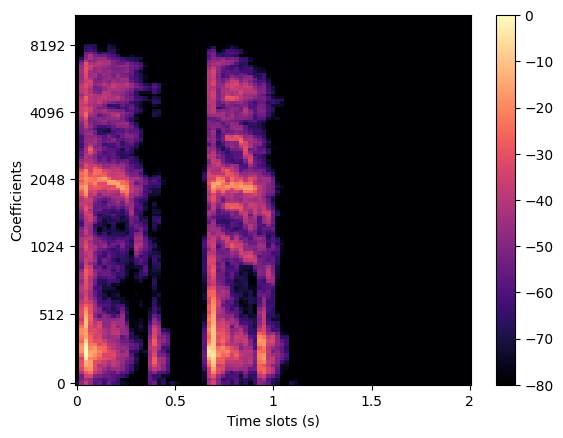

(128, 87)

In [ ]:
melspecs = librosa.feature.melspectrogram(y=prova, sr=sr, n_fft=1024)
S_dB = librosa.power_to_db(melspecs, ref=np.max)
specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.colorbar()
plt.show()
melspecs.shape

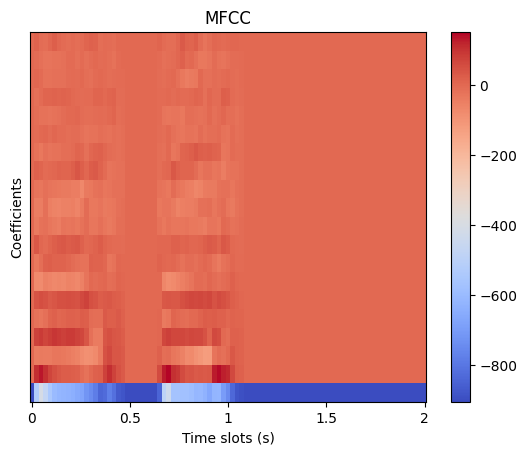

(20, 87)

In [ ]:
# spectral rappresentation: mfcc
mfccs = mfcc(S=S_dB)
specshow(mfccs, sr=sr, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()
mfccs.shape

# Classification

## Baseline classification results: expert diagnosis


I established a benchmark by comparing patient status and expert diagnosis, for both the binary (healthy vs not healthy) and non binary (healthy vs symptomatic vs COVID-19) classification version of the problem.

It appears that, even for expert physicians, formulating a correct diagnosis based on a cough recording it's a relatively hard task. Physician's diagnosis scores a weighted f1 score of 0.61 and 0.38 for the binary healthy-vs-rest and non binary classification task respectively. Overall we can observe a tendency to over-diagnose non healthy status and under-diagnose COVID-19 cases.

classification report:

              precision    recall  f1-score   support

    COVID-19       0.26      0.19      0.22       509
     healthy       0.35      0.25      0.29       611
 symptomatic       0.47      0.64      0.54       877

    accuracy                           0.40      1997
   macro avg       0.36      0.36      0.35      1997
weighted avg       0.38      0.40      0.38      1997


confusion matrix:



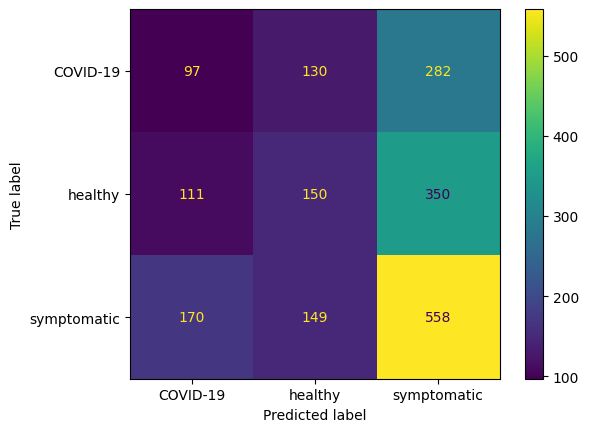

In [ ]:
# scoring the diagnosis as a three class classification task, status as ground truth
diagnosis = metadata_sel[metadata_sel.diagnosis.notna()].diagnosis.values
status = metadata_sel[metadata_sel.diagnosis.notna()].status.values

print('classification report:\n')
print(classification_report(status, diagnosis))

print('\nconfusion matrix:\n')
lbl=['COVID-19','healthy', 'symptomatic']
cm = confusion_matrix(status, diagnosis, labels=lbl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbl)
disp.plot()
plt.show()

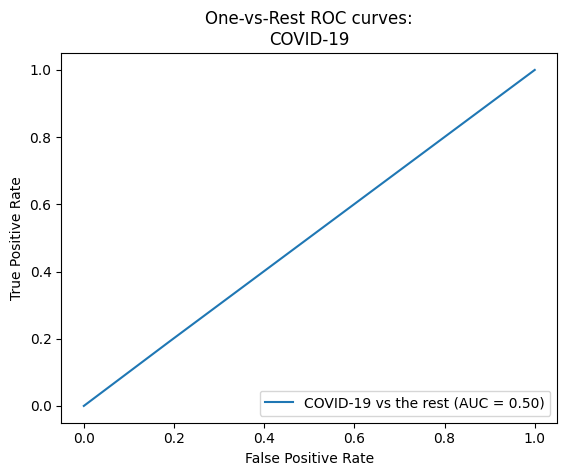

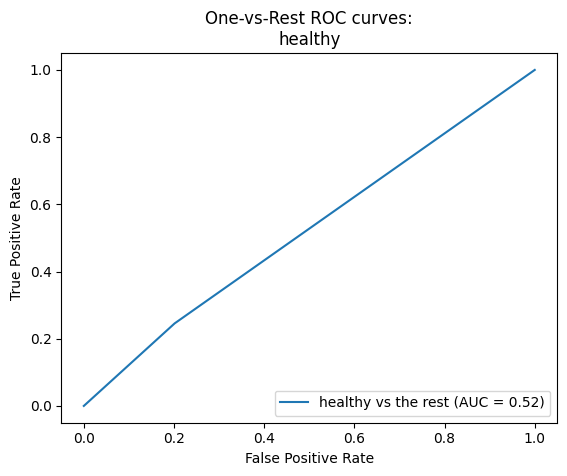

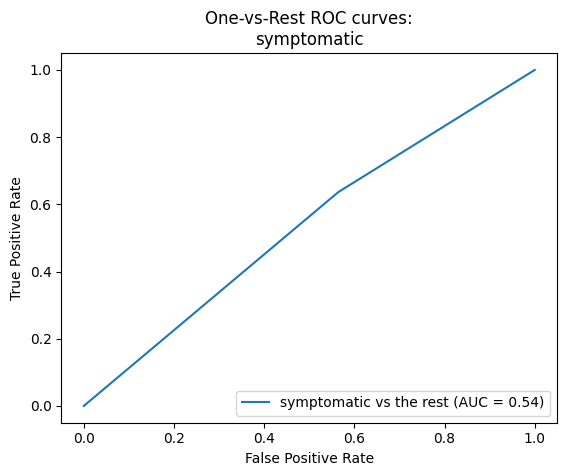

In [ ]:
label_binarizer = LabelBinarizer().fit(status)
y_onehot_test = label_binarizer.transform(status)
y_score = label_binarizer.transform(diagnosis)

for cl in lbl:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

classification report (1:healthy; 0:not healthy):

              precision    recall  f1-score   support

       False       0.71      0.80      0.75      1386
        True       0.35      0.25      0.29       611

    accuracy                           0.63      1997
   macro avg       0.53      0.52      0.52      1997
weighted avg       0.60      0.63      0.61      1997


confusion matrix (1:healthy; 0:not healthy):



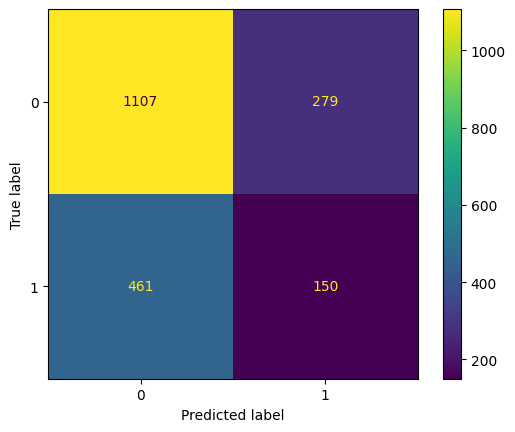

In [ ]:
# scoring the diagnosis as a binary classification task (healty vs not healthy), status as ground truth
diagnosis = metadata_sel[metadata_sel.diagnosis.notna()].diagnosis_healthy.values
status = metadata_sel[metadata_sel.diagnosis.notna()].status_healthy.values

print('classification report (1:healthy; 0:not healthy):\n')
print(classification_report(status, diagnosis))

print('\nconfusion matrix (1:healthy; 0:not healthy):\n')
cm = confusion_matrix(status, diagnosis)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

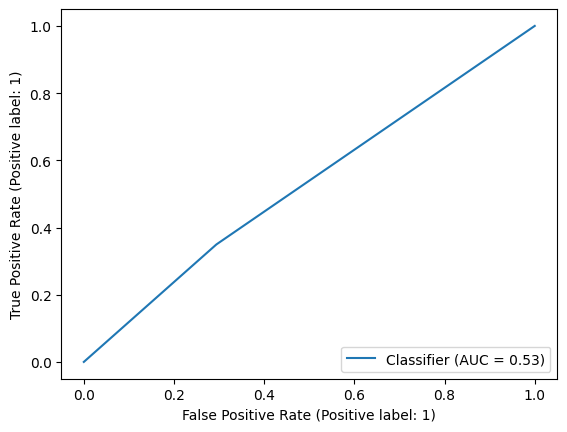

In [ ]:
RocCurveDisplay.from_predictions(diagnosis,status)
plt.show()

## Train/Test split

Train and test groups were split on a record level base; this prevents information leaking by ensuring that clips ectracted from the same recording to be either in training or in test, but not in both.

In [ ]:
# split train and test istances on a record level base
train, test = train_test_split(metadata_sel, train_size=0.7, stratify=metadata_sel.status, shuffle=True, random_state=721)

In [ ]:
# matches extracted spectrograms to the respective matadata features
def record_feature_matching(tt_df, og_df, bn=False):
  tt_df_coughs = pd.DataFrame(columns=og_df.columns)
  tt_df_target = []
  tt_df_gender = []
  tt_df_age = []
  for rec in tqdm(tt_df.itertuples()):
    cur_df = og_df[og_df.uuid==rec.uuid]
    if bn:
      cur_target = rec.status_healthy
    else:
      cur_target = rec.status
    cur_age = rec.age
    cur_gender = 1 if rec.gender=='female' else 0
    tt_df_coughs = pd.concat([tt_df_coughs, cur_df], ignore_index=True)
    for i in range(len(cur_df)):
      tt_df_target.append(cur_target)
      tt_df_age.append(cur_age)
      tt_df_gender.append(cur_gender)
  tt_df_coughs['age'] = tt_df_age
  tt_df_coughs['gender'] = tt_df_gender
  return(tt_df_coughs, tt_df_target)

## Feature extractor definition

In [ ]:
# extracts summary fatures from spectrograms either by row, column, or both and concatenates them into a list
# summary feature list: average, median, standard deviation, maximum

def feature_extract(tt_df, axis='row', median=True, demo_info=False, spec_type='mfcc'):
  tt_df_coughs_features = []
  for i,item in tqdm(enumerate(tt_df[spec_type])):
    cur_feat = []
    if axis in ['col','both']:
      cur_mean = item.mean(axis=0)
      cur_std = item.std(axis=0)
      cur_max = np.argmax(item, axis=0)
      cur_feat = np.concatenate((cur_feat, cur_mean, cur_std, cur_max), axis=None)
    if axis in ['row','both']:
      cur_mean = item.mean(axis=1)
      cur_std = item.std(axis=1)
      cur_max = np.argmax(item, axis=1)
      cur_feat = np.concatenate((cur_feat, cur_mean, cur_std, cur_max), axis=None)
    if median:
      cur_median = np.argsort(item)[len(item)//2]
      cur_feat = np.concatenate((cur_feat, cur_median), axis=None)
    if demo_info:
      cur_gender = tt_df.iloc[i].gender
      cur_age = tt_df.iloc[i].age
      cur_feat = np.concatenate((cur_feat, cur_age, cur_gender), axis=None)
    tt_df_coughs_features.append(cur_feat)
  return tt_df_coughs_features

## Whole audio classification

In [ ]:
file_path = '/content/drive/MyDrive/WIP/DSIM/project/coughs_mfccs_mel_whole.pickle'
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    coughs_df = pickle.load(file)

coughs_df

,uuid,mel_spec,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,"[[-80.0, -80.0, -80.0, -40.253853, -37.778214,...","[[-905.0967, -905.0967, -905.0967, -446.28165,..."
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -61.36065...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
4,00291cce-36a0-4a29-9e2d-c1d96ca17242,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
...,...,...,...
12164,ffe0658f-bade-4654-ad79-40a468aabb03,"[[-80.0, -75.99041, -76.52704, -80.0, -80.0, -...","[[-905.0967, -904.74225, -904.78973, -905.0967..."
12165,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
12166,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -905.0967, -905.0967, ..."
12167,ffeea120-92a4-40f9-b692-c3865c7a983f,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-905.0967, -905.0967, -903.2958, -903.843, -..."


In [ ]:
# zero padding or cut spectrograms to make each recording the same length (10s)

# set target length in seconds
target_length = 10
target = librosa.time_to_frames(target_length)

# zero pad mfccs
new_cough_mfcc = []
for i in range(0,len(coughs_df)):
  cur_cough = coughs_df['mfcc'][i]
  pad = target - cur_cough.shape[1]
  if pad >0:
    cur_new_cough_mfcc = np.pad(cur_cough,((0,0),(0,pad)))
  else:
    cur_new_cough_mfcc = cur_cough[:,0:target]
  new_cough_mfcc.append(cur_new_cough_mfcc)
coughs_df['mfcc'] = new_cough_mfcc
# clear memory
del new_cough_mfcc

# zero pad mel spectrograms
new_cough_mel = []
for i in range(0,len(coughs_df)):
  cur_cough = coughs_df['mel_spec'][i]
  pad = target - cur_cough.shape[1]
  if pad >0:
    cur_new_cough_mel = np.pad(cur_cough,((0,0),(0,pad)))
  else:
    cur_new_cough_mel = cur_cough[:,0:target]
  new_cough_mel.append(cur_new_cough_mel)
coughs_df['mel_spec'] = new_cough_mel
# clear memory
del new_cough_mel

#### mfcc

In [ ]:
# match recordings and clips features
print('matching recordings and clips features...')
train_coughs, train_target = record_feature_matching(train,coughs_df, bn=False)
test_coughs, test_target = record_feature_matching(test,coughs_df, bn=False)

# # spec self normalization
# print('\nself-normalizing features...')
# transformer = MinMaxScaler()
# train_coughs['mfcc'] = train_coughs['mfcc'].progress_apply(transformer.fit_transform)
# test_coughs['mfcc'] = test_coughs['mfcc'].progress_apply(transformer.fit_transform)
# train_coughs['mel_spec'] = train_coughs['mel_spec'].progress_apply(transformer.fit_transform)
# test_coughs['mel_spec'] = test_coughs['mel_spec'].progress_apply(transformer.fit_transform)

# extract features from clips
print('\nextracting features...')
train_coughs_features = feature_extract(train_coughs, axis='both', demo_info=True, spec_type='mfcc')
test_coughs_features = feature_extract(test_coughs, axis='both', demo_info=True, spec_type='mfcc')

# feature standardization
transformer = StandardScaler().fit(train_coughs_features)
train_coughs_features = transformer.transform(train_coughs_features)
test_coughs_features = transformer.transform(test_coughs_features)

# check feature shape
print('\n\ntrain feature shape:'+str(train_coughs_features.shape))
print('test feature shape:'+str(test_coughs_features.shape))

matching recordings and clips features...

extracting features...


8518it [00:15, 542.75it/s]
3651it [00:06, 554.29it/s] 




train feature shape:(8518, 1782)
test feature shape:(3651, 1782)


In [ ]:
# Classifier initialization
clf = ensemble.HistGradientBoostingClassifier(class_weight='balanced', scoring='f1_macro', max_depth=3,
                                              early_stopping=False, verbose=1, max_iter=10)

# Training
clf = clf.fit(train_coughs_features, np.array(train_target))

Binning 0.121 GB of training data: 4.588 s
Fitting gradient boosted rounds:
[1/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.471s
[2/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 1.380s
[3/10] 3 trees, 23 leaves (7 on avg), max depth = 3, in 1.309s
[4/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.455s
[5/10] 3 trees, 23 leaves (7 on avg), max depth = 3, in 0.225s
[6/10] 3 trees, 23 leaves (7 on avg), max depth = 3, in 0.232s
[7/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.244s
[8/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.236s
[9/10] 3 trees, 23 leaves (7 on avg), max depth = 3, in 0.238s
[10/10] 3 trees, 23 leaves (7 on avg), max depth = 3, in 0.222s
Fit 30 trees in 9.644 s, (235 total leaves)
Time spent computing histograms: 2.731s
Time spent finding best splits:  1.193s
Time spent applying splits:      0.780s
Time spent predicting:           0.016s


In [ ]:
# train set score (cheking for overfitting)
y_pred = clf.predict(train_coughs_features)
print(classification_report(np.array(train_target),y_pred))

              precision    recall  f1-score   support

    COVID-19       0.16      0.71      0.26       433
     healthy       0.85      0.51      0.64      6253
 symptomatic       0.36      0.55      0.43      1832

    accuracy                           0.53      8518
   macro avg       0.46      0.59      0.44      8518
weighted avg       0.71      0.53      0.57      8518



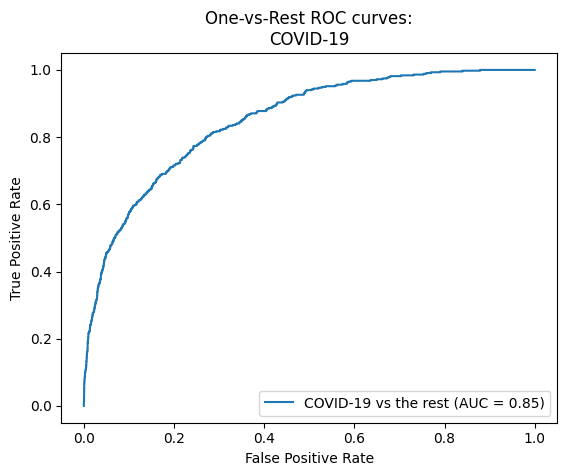

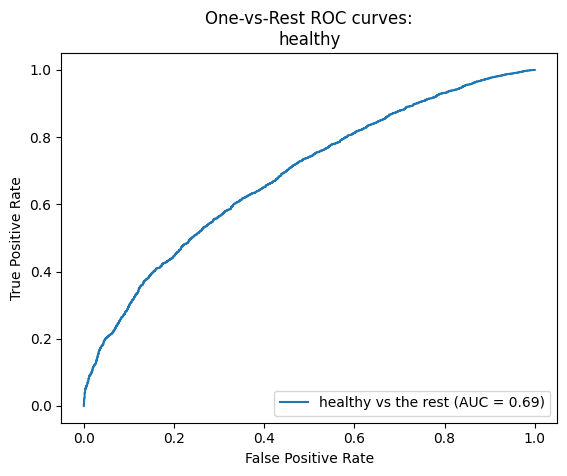

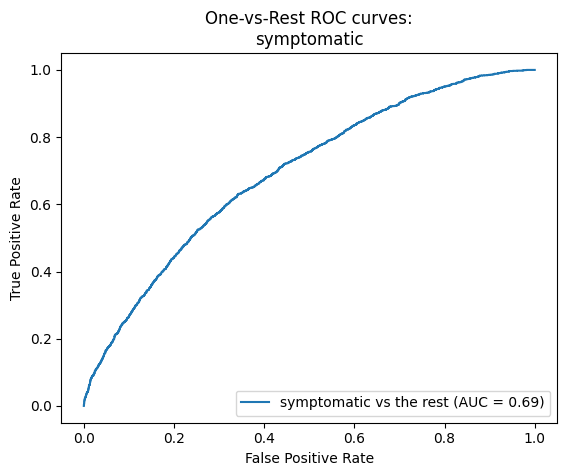

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(train_target)
y_score = clf.predict_proba(train_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

In [ ]:
# test set score
y_pred = clf.predict(test_coughs_features)
print(classification_report(np.array(test_target), y_pred))

              precision    recall  f1-score   support

    COVID-19       0.08      0.32      0.12       185
     healthy       0.80      0.48      0.60      2681
 symptomatic       0.29      0.46      0.35       785

    accuracy                           0.47      3651
   macro avg       0.39      0.42      0.36      3651
weighted avg       0.65      0.47      0.52      3651



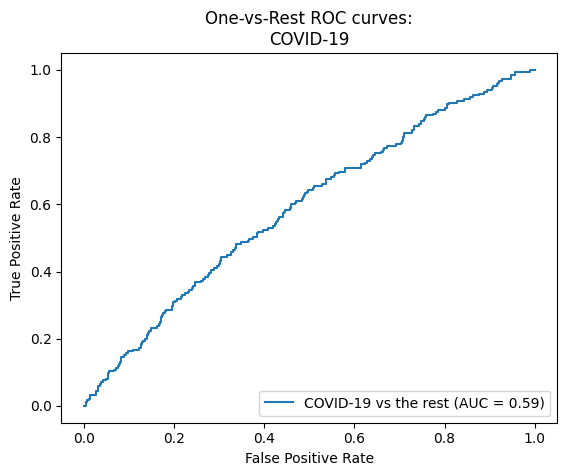

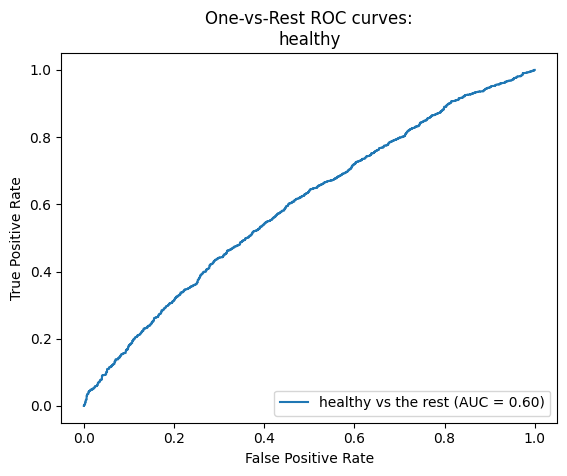

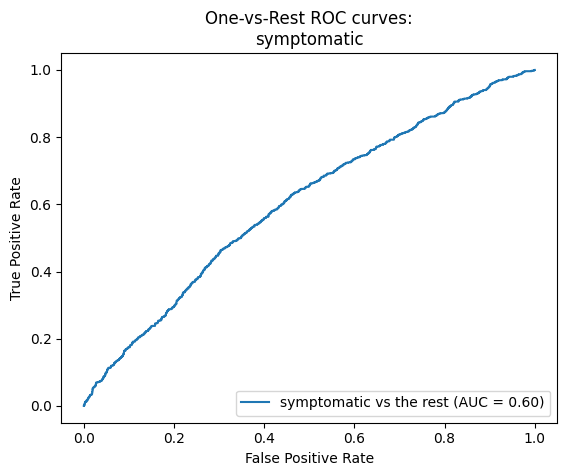

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(test_target)
y_score = clf.predict_proba(test_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

#### mel spectrogram

In [ ]:
# match recordings and clips features
print('matching recordings and clips features...')
train_coughs, train_target = record_feature_matching(train,coughs_df, bn=False)
test_coughs, test_target = record_feature_matching(test,coughs_df, bn=False)

# extract features from clips
print('\nextracting features...')
train_coughs_features = feature_extract(train_coughs, axis='both', demo_info=True, spec_type='mel_spec')
test_coughs_features = feature_extract(test_coughs, axis='both', demo_info=True, spec_type='mel_spec')

# feature standardization
transformer = StandardScaler().fit(np.array(train_coughs_features))
train_coughs_features = transformer.transform(np.array(train_coughs_features))
test_coughs_features = transformer.transform(np.array(test_coughs_features))

# check feature shape
print('\nfeature shape:'+str(train_coughs_features.shape))

matching recordings and clips features...


8518it [00:27, 311.24it/s]
3651it [00:10, 334.26it/s]



extracting features...


8518it [00:23, 367.74it/s]
3651it [00:10, 341.71it/s]



feature shape:(8518, 2106)


In [ ]:
# Classifier initialization
clf = ensemble.HistGradientBoostingClassifier(class_weight='balanced', scoring='f1_macro', max_depth=3, verbose=1, max_iter=10)

# Training
clf = clf.fit(train_coughs_features, train_target)

Binning 0.144 GB of training data: 9.056 s
Fitting gradient boosted rounds:
[1/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.768s
[2/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.670s
[3/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 1.240s
[4/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.766s
[5/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.690s
[6/10] 3 trees, 23 leaves (7 on avg), max depth = 3, in 0.832s
[7/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 1.521s
[8/10] 3 trees, 21 leaves (7 on avg), max depth = 3, in 1.537s
[9/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 1.412s
[10/10] 3 trees, 24 leaves (8 on avg), max depth = 3, in 0.984s
Fit 30 trees in 19.540 s, (236 total leaves)
Time spent computing histograms: 5.416s
Time spent finding best splits:  2.919s
Time spent applying splits:      1.737s
Time spent predicting:           0.055s


In [ ]:
# train set score (cheking for overfitting)
y_pred = clf.predict(train_coughs_features)
print(classification_report(train_target, y_pred))

              precision    recall  f1-score   support

    COVID-19       0.17      0.69      0.27       433
     healthy       0.85      0.51      0.64      6253
 symptomatic       0.35      0.57      0.43      1832

    accuracy                           0.53      8518
   macro avg       0.46      0.59      0.45      8518
weighted avg       0.71      0.53      0.57      8518



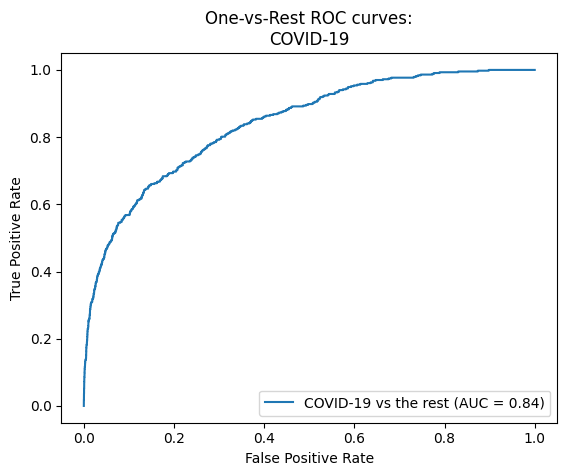

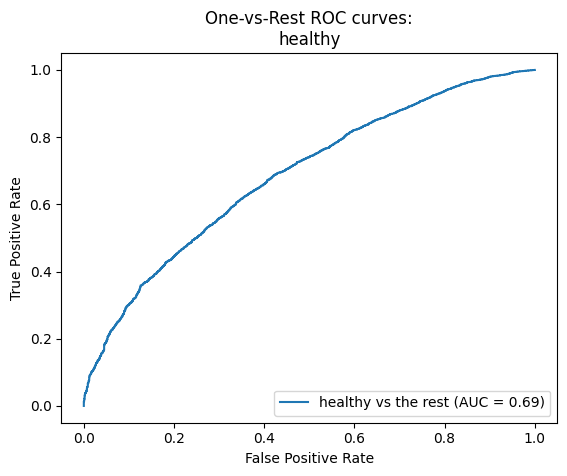

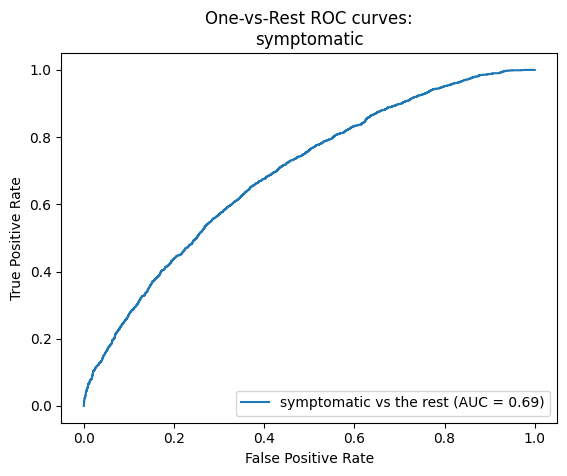

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(train_target)
y_score = clf.predict_proba(train_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

In [ ]:
# test set score
y_pred = clf.predict(test_coughs_features)
print(classification_report(test_target, y_pred))

              precision    recall  f1-score   support

    COVID-19       0.07      0.28      0.11       185
     healthy       0.80      0.48      0.60      2681
 symptomatic       0.28      0.47      0.35       785

    accuracy                           0.47      3651
   macro avg       0.38      0.41      0.36      3651
weighted avg       0.65      0.47      0.52      3651



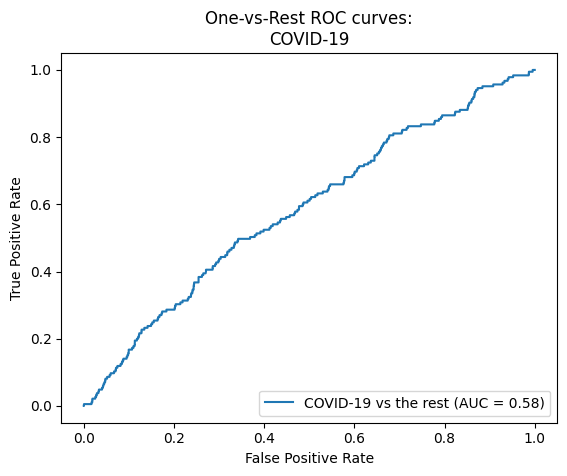

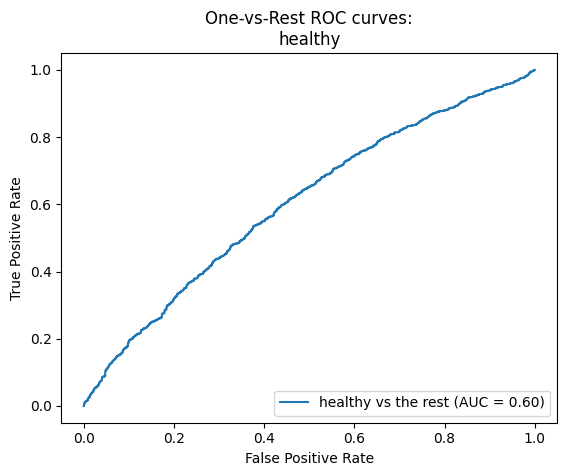

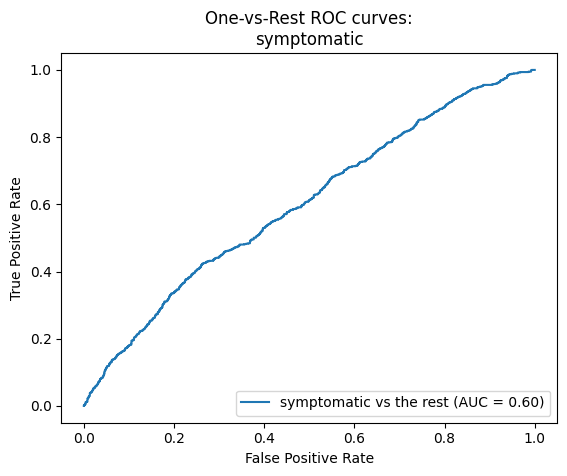

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(test_target)
y_score = clf.predict_proba(test_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

## 2s clips classification

In [ ]:
file_path = '/content/drive/MyDrive/WIP/DSIM/project/coughs_mfccs_mel_2s.pickle'
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    coughs_df = pickle.load(file)

coughs_df

,uuid,prog,mel_spec,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,0,"[[-79.47978, -46.708015, -37.06755, -35.75215,...","[[-889.4925, -506.90012, -348.68088, -331.9238..."
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,1,"[[-80.0, -46.147816, -36.391365, -46.22757, -5...","[[-903.8082, -462.52716, -396.05963, -496.2419..."
2,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0,"[[-64.58925, -41.23861, -29.949255, -40.059586...","[[-581.22046, -441.2168, -417.69836, -408.7375..."
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,1,"[[-44.95310825440177, -52.13346221336771, -42....","[[-583.2834931765963, -464.4748148194519, -453..."
4,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0,"[[-54.15815, -30.446606, -38.034794, -44.34784...","[[-692.4205, -309.34384, -274.4766, -303.20404..."
...,...,...,...,...
23174,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,2,"[[-80.0, -51.852707, -37.71869, -48.245567, -3...","[[-902.3189, -427.1466, -304.74515, -286.61664..."
23175,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,0,"[[-66.16517, -47.74669, -36.226467, -35.426918...","[[-812.72266, -556.7373, -431.46884, -441.1711..."
23176,ffeea120-92a4-40f9-b692-c3865c7a983f,0,"[[-80.0, -44.35447, -31.459274, -49.961884, -5...","[[-905.0967, -415.8689, -307.7343, -391.33337,..."
23177,ffeea120-92a4-40f9-b692-c3865c7a983f,1,"[[-59.765297, -53.43869, -44.30625, -41.577538...","[[-834.8248, -569.4282, -333.76074, -333.09717..."


#### mfcc

In [ ]:
# match recordings and clips features
# print('matching recordings and clips features...')
train_coughs, train_target = record_feature_matching(train,coughs_df, bn=False)
test_coughs, test_target = record_feature_matching(test,coughs_df, bn=False)

# spec self normalization
# print('\nself-normalizing features...')
# transformer = MinMaxScaler()
# train_coughs['mfcc'] = train_coughs['mfcc'].progress_apply(transformer.fit_transform)
# test_coughs['mfcc'] = test_coughs['mfcc'].progress_apply(transformer.fit_transform)
# train_coughs['mel_spec'] = train_coughs['mel_spec'].progress_apply(transformer.fit_transform)
# test_coughs['mel_spec'] = test_coughs['mel_spec'].progress_apply(transformer.fit_transform)

# extract features from clips
print('\nextracting features...')
train_coughs_features = feature_extract(train_coughs, axis='both', demo_info=True, spec_type='mfcc')
test_coughs_features = feature_extract(test_coughs, axis='both', demo_info=True, spec_type='mfcc')

# feature standardization
transformer = StandardScaler().fit(train_coughs_features)
train_coughs_features = transformer.transform(train_coughs_features)
test_coughs_features = transformer.transform(test_coughs_features)

# check feature shape
print('\nfeature shape:'+str(np.array(train_coughs_features).shape))

8518it [00:53, 157.96it/s]
3651it [00:15, 229.19it/s]



extracting features...


16257it [00:11, 1473.57it/s]
6922it [00:04, 1441.74it/s]



feature shape:(16257, 410)


In [ ]:
# Classifier initialization
clf = ensemble.HistGradientBoostingClassifier(class_weight='balanced', scoring='f1_macro', early_stopping=True, max_depth=5,
                                              verbose=1)

# Training
clf = clf.fit(train_coughs_features, train_target)

Binning 0.048 GB of training data: 2.600 s
Binning 0.005 GB of validation data: 0.182 s
Fitting gradient boosted rounds:
[1/100] 3 trees, 91 leaves (30 on avg), max depth = 5, train score: 0.52341, val score: 0.40667, in 0.838s
[2/100] 3 trees, 90 leaves (30 on avg), max depth = 5, train score: 0.55574, val score: 0.42449, in 0.963s
[3/100] 3 trees, 86 leaves (28 on avg), max depth = 5, train score: 0.57690, val score: 0.45483, in 1.136s
[4/100] 3 trees, 87 leaves (29 on avg), max depth = 5, train score: 0.59921, val score: 0.44489, in 0.241s
[5/100] 3 trees, 92 leaves (30 on avg), max depth = 5, train score: 0.62278, val score: 0.43625, in 0.251s
[6/100] 3 trees, 88 leaves (29 on avg), max depth = 5, train score: 0.63930, val score: 0.42819, in 0.249s
[7/100] 3 trees, 83 leaves (27 on avg), max depth = 5, train score: 0.64754, val score: 0.41833, in 0.234s
[8/100] 3 trees, 85 leaves (28 on avg), max depth = 5, train score: 0.65691, val score: 0.42581, in 0.254s
[9/100] 3 trees, 84 lea

In [ ]:
# train set score (cheking for overfitting)
y_pred = clf.predict(train_coughs_features)
print(classification_report(train_target, y_pred))

              precision    recall  f1-score   support

    COVID-19       0.25      0.84      0.38       857
     healthy       0.89      0.58      0.70     11836
 symptomatic       0.42      0.66      0.51      3564

    accuracy                           0.61     16257
   macro avg       0.52      0.69      0.53     16257
weighted avg       0.75      0.61      0.64     16257



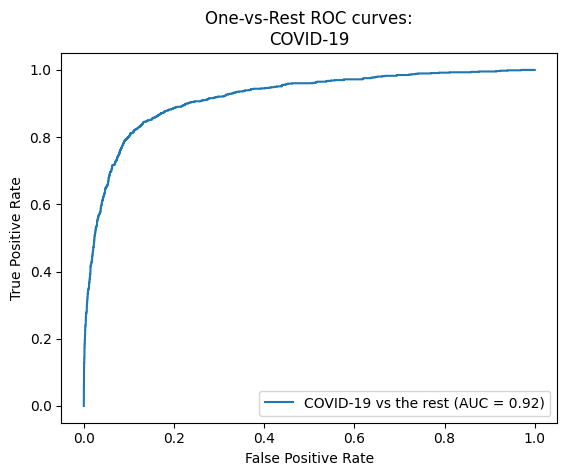

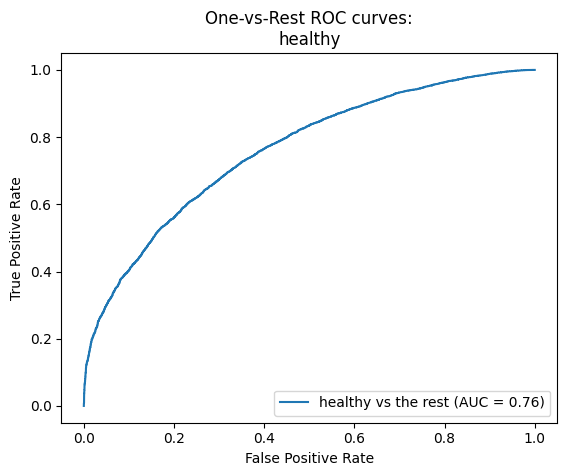

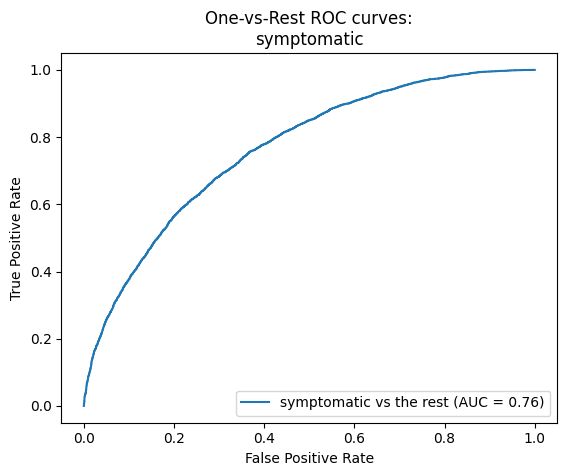

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(train_target)
y_score = clf.predict_proba(train_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

In [ ]:
# test set score
y_pred = clf.predict(test_coughs_features)
print(classification_report(test_target, y_pred))

              precision    recall  f1-score   support

    COVID-19       0.07      0.23      0.11       365
     healthy       0.79      0.53      0.63      5022
 symptomatic       0.31      0.48      0.37      1535

    accuracy                           0.50      6922
   macro avg       0.39      0.41      0.37      6922
weighted avg       0.64      0.50      0.55      6922



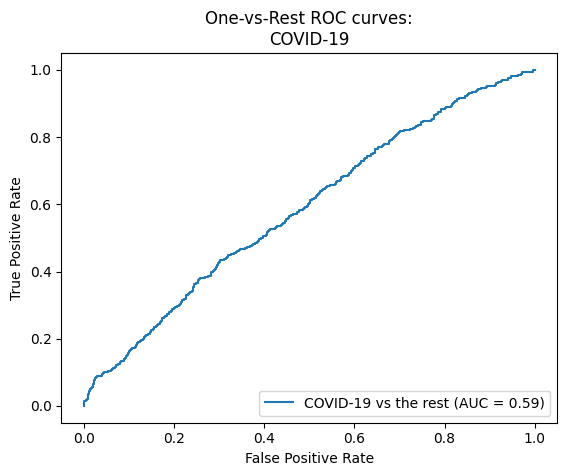

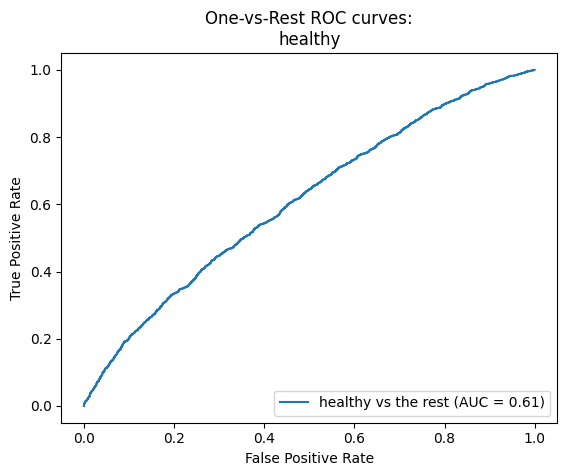

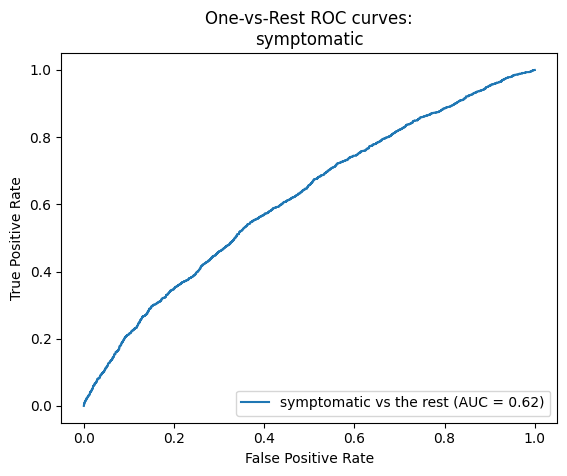

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(test_target)
y_score = clf.predict_proba(test_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

#### mel spectrogram

In [ ]:
# spec self normalization
# print('\nself-normalizing features...')
# transformer = MinMaxScaler()
# train_coughs['mfcc'] = train_coughs['mfcc'].progress_apply(transformer.fit_transform)
# test_coughs['mfcc'] = test_coughs['mfcc'].progress_apply(transformer.fit_transform)
# train_coughs['mel_spec'] = train_coughs['mel_spec'].progress_apply(transformer.fit_transform)
# test_coughs['mel_spec'] = test_coughs['mel_spec'].progress_apply(transformer.fit_transform)

# extract features from clips
print('\nextracting features...')
train_coughs_features = feature_extract(train_coughs, axis='both', demo_info=True, spec_type='mel_spec')
test_coughs_features = feature_extract(test_coughs, axis='both', demo_info=True, spec_type='mel_spec')

# feature standardization
transformer = StandardScaler().fit(train_coughs_features)
train_coughs_features = transformer.transform(train_coughs_features)
test_coughs_features = transformer.transform(test_coughs_features)

# check feature shape
print('\nfeature shape:'+str(np.array(train_coughs_features).shape))


extracting features...


16257it [00:29, 542.61it/s]
6922it [00:07, 925.62it/s] 



feature shape:(16257, 734)


In [ ]:
# Classifier initialization
clf = ensemble.HistGradientBoostingClassifier(class_weight='balanced', scoring='f1_macro', early_stopping=True, max_depth=5,
                                              verbose=1)

# Training
clf = clf.fit(train_coughs_features, train_target)

Binning 0.086 GB of training data: 2.384 s
Binning 0.010 GB of validation data: 0.079 s
Fitting gradient boosted rounds:
[1/100] 3 trees, 87 leaves (29 on avg), max depth = 5, train score: 0.52088, val score: 0.42576, in 0.370s
[2/100] 3 trees, 93 leaves (31 on avg), max depth = 5, train score: 0.56410, val score: 0.45173, in 0.423s
[3/100] 3 trees, 90 leaves (30 on avg), max depth = 5, train score: 0.58725, val score: 0.45506, in 0.385s
[4/100] 3 trees, 87 leaves (29 on avg), max depth = 5, train score: 0.59292, val score: 0.45592, in 0.387s
[5/100] 3 trees, 87 leaves (29 on avg), max depth = 5, train score: 0.60292, val score: 0.46166, in 0.434s
[6/100] 3 trees, 82 leaves (27 on avg), max depth = 5, train score: 0.61171, val score: 0.45502, in 1.229s
[7/100] 3 trees, 70 leaves (23 on avg), max depth = 5, train score: 0.62404, val score: 0.46285, in 1.502s
[8/100] 3 trees, 71 leaves (23 on avg), max depth = 5, train score: 0.62715, val score: 0.45390, in 0.941s
[9/100] 3 trees, 69 lea

In [ ]:
# train set score (cheking for overfitting)
y_pred = clf.predict(train_coughs_features)
print(classification_report(train_target, y_pred))

              precision    recall  f1-score   support

    COVID-19       0.22      0.84      0.34       857
     healthy       0.90      0.54      0.68     11836
 symptomatic       0.42      0.67      0.51      3564

    accuracy                           0.59     16257
   macro avg       0.51      0.69      0.51     16257
weighted avg       0.76      0.59      0.62     16257



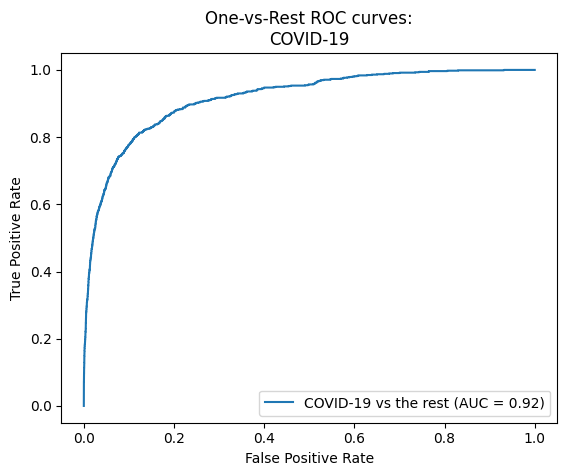

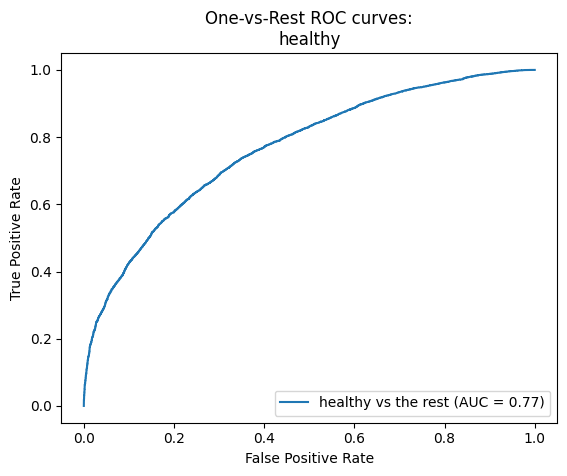

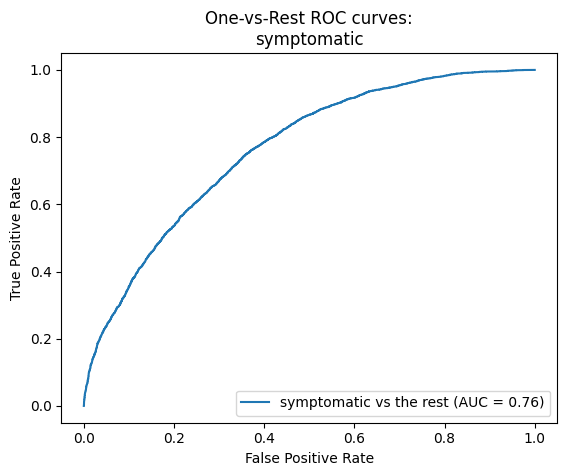

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(train_target)
y_score = clf.predict_proba(train_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )

In [ ]:
# test set score
y_pred = clf.predict(test_coughs_features)
print(classification_report(test_target, y_pred))

              precision    recall  f1-score   support

    COVID-19       0.07      0.30      0.12       365
     healthy       0.79      0.48      0.60      5022
 symptomatic       0.31      0.47      0.37      1535

    accuracy                           0.47      6922
   macro avg       0.39      0.42      0.36      6922
weighted avg       0.64      0.47      0.52      6922



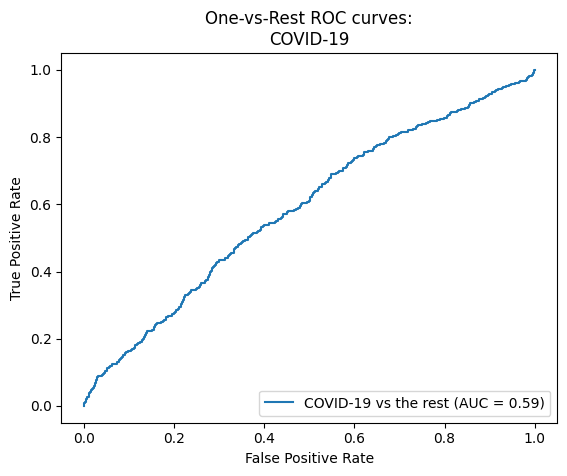

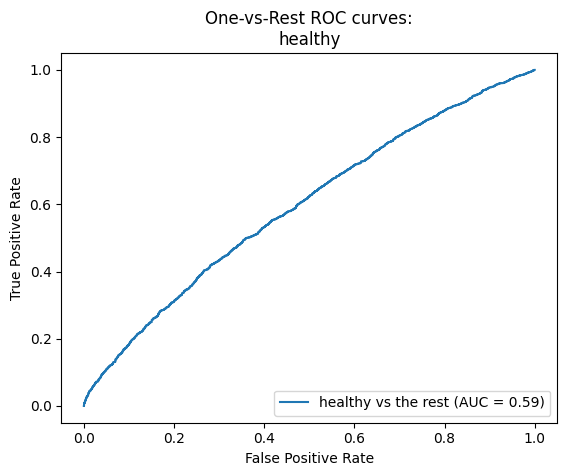

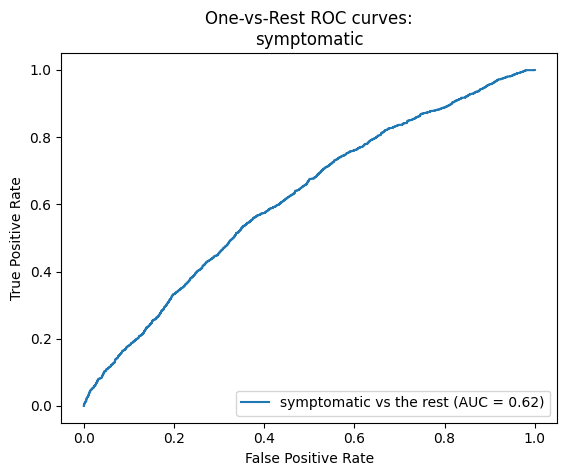

In [ ]:
label_binarizer = LabelBinarizer().fit(train_target)
y_onehot_test = label_binarizer.transform(test_target)
y_score = clf.predict_proba(test_coughs_features)

for cl in clf.classes_:
  class_of_interest = cl
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  display = RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      y_score[:, class_id],
      name=f"{class_of_interest} vs the rest",
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
  )